In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [95]:
IAH_BOS_FP_track = pd.read_csv(os.getcwd() + '/FlightPlans/FlightPlans_IAH_BOS_2013/FP_PT.CSV', usecols=[0,1,2])
IAH_BOS_FP_utilize = pd.read_csv(os.getcwd() + '/FlightPlans/FlightPlans_IAH_BOS_2013/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV', 
                             usecols=[19,1])
IAH_BOS_ACT_track = pd.read_csv(os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv', header = 0, usecols = [0, 7, 8, 9, 12])

In [101]:
track_with_FP_id = IAH_BOS_ACT_track.merge(IAH_BOS_FP_utilize, left_on='FID', right_on='FID')

In [103]:
IAH_BOS_FP_track = IAH_BOS_FP_track.drop_duplicates(["FLT_PLAN_ID", "LATITUDE", "LONGITUDE"])
IAH_BOS_FP_track.to_csv(os.getcwd() + '/FlightPlans/FlightPlans_IAH_BOS_2013/cleaned_FP_tracks.CSV', index=False)

In [154]:
FP_track_wide = IAH_BOS_FP_track.groupby('FLT_PLAN_ID').apply(lambda x: x[['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)).reset_index()
FP_track_wide.columns = ['FLT_PLAN_ID', 'FP_tracks']
FP_track_wide['seq_len'] = FP_track_wide.FP_tracks.apply(lambda x: x.shape[1]//2)

In [155]:
track_with_FP = track_with_FP_id.merge(FP_track_wide, left_on='FLT_PLAN_ID', right_on = 'FLT_PLAN_ID')

In [182]:
FP_track_order = track_with_FP.groupby('FID')[['FP_tracks', 'seq_len']].head(1)
seq_length_FP = FP_track_order.seq_len.values.astype(np.int32)
FP_tracks_split = FP_track_order.FP_tracks.values

In [229]:
track_with_FP_id.FID.unique()

array([20130101632288, 20130101635086, 20130101663353, ...,
       20131231490984, 20131231518394, 20131231523303], dtype=int64)

In [12]:
actual_track_datapath = '../data/New_IAHBOS2013.csv'
flight_plan_utilize_datapath = '../data/IAH_BOS_Act_Flt_Trk_20130101_1231.CSV'
flight_plan_datapath = '../data/cleaned_FP_tracks.CSV'

def _pad_FP(inputs, inputs_len):
    max_len = inputs_len.max()
    _inputs = []
    i = 0
    for _input in inputs:
        _inputs.append(np.pad(_input.reshape(-1,2), ((0, max_len - inputs_len[i]), (0,0)), 'constant', constant_values = 0))
        i+=1
    return np.asarray(_inputs)

def _pad(inputs, inputs_len):
    # inputs is a list of np arrays
    # inputs_len is a np array

    max_len = inputs_len.max()
    _inputs = []
    i = 0
    for _input in inputs:
        _inputs.append(np.pad(_input, ((0, max_len - inputs_len[i]), (0,0)), 'constant', constant_values = 0))
        i+=1
    return np.asarray(_inputs)
    
track_data = pd.read_csv(actual_track_datapath, header = 0, usecols = [0, 7, 8, 9, 12])
FP_track = pd.read_csv(flight_plan_datapath)
FP_utlize = pd.read_csv(flight_plan_utilize_datapath, header = 0, usecols = [19,1])
# track_data_with_FP_id = track_data.merge(FP_utlize, left_on = 'FID', right_on = 'FID', how = 'inner')
# track_data_with_FP = track_data_with_FP_id.merge(FP_track_wide, left_on='FLT_PLAN_ID', right_on = 'FLT_PLAN_ID')

# seq_length_tracks = track_data_with_FP.groupby('FID').FLT_PLAN_ID.count().values.astype(np.int32)
# tracks = track_data_with_FP[['Lat', 'Lon', 'Alt', 'DT']].values.astype(np.float32)
# avg = tracks.mean(axis = 0)
# std_err = tracks.std(axis = 0)
# # tracks = (tracks - avg)/std_err
# tracks_split = np.split(tracks, np.cumsum(seq_length_tracks))[:-1]
# tracks_split = _pad(tracks_split, seq_length_tracks)

# # process FP tracks
# FP_track_wide = FP_track.groupby('FLT_PLAN_ID').apply(lambda x: x[['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)).reset_index()
# FP_track_wide.columns = ['FLT_PLAN_ID', 'FP_tracks']
# FP_track_wide['seq_len'] = FP_track_wide.FP_tracks.apply(lambda x: x.shape[1]//2)
# FP_track_order = track_data_with_FP.groupby('FID')[['FP_tracks', 'seq_len']].head(1)

# seq_length_FP = FP_track_order.seq_len.values.astype(np.int32)
# FP_tracks_split = FP_track_order.FP_tracks.values

# FP_tracks_split = _pad_FP(FP_tracks_split, seq_length_FP)
# avg_FP = FP_tracks_split.mean(axis = 0).mean(axis = 0)
# std_err_FP = FP_tracks_split.std(axis = 0).std(axis = 0)
# # FP_tracks_split = (FP_tracks_split - avg_FP)/std_err_FP  

In [205]:
def _pad_FP(inputs, inputs_len):
    max_len = inputs_len.max()
    print(max_len)
    _inputs = []
    i = 0
    for _input in inputs:
        _inputs.append(np.pad(_input.reshape(-1,2), ((0, max_len - inputs_len[i]), (0,0)), 'constant', constant_values = 0))
        i+=1
    return np.asarray(_inputs)

In [17]:
def plot_fp_act(FP_ID, IAH_BOS_FP_utilize, IAH_BOS_ACT_track, IAH_BOS_FP_track):
    fig = plt.figure(figsize=(12,8))
    m = Basemap(llcrnrlon = -100,llcrnrlat = 27,urcrnrlon = -68,urcrnrlat = 46,projection='merc')
    m.bluemarble()
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawstates(linewidth=0.5)
    m.drawparallels(np.arange(10.,35.,5.))
    m.drawmeridians(np.arange(-120.,-80.,10.))

    fid_fp1 = IAH_BOS_FP_utilize.loc[IAH_BOS_FP_utilize.FLT_PLAN_ID == FP_ID, 'FID'].values
    print('%d flights filed flight plan %s'%(fid_fp1.shape[0], FP_ID))
    plot_track = IAH_BOS_ACT_track.loc[IAH_BOS_ACT_track.FID.isin(fid_fp1)]
    plot_fp = IAH_BOS_FP_track.loc[IAH_BOS_FP_track.FLT_PLAN_ID == FP_ID]
    x_fp, y_fp = m(plot_fp.LONGITUDE.values, plot_fp.LATITUDE.values)

    for gpidx, gp in plot_track.groupby('FID'):
        x,y = m(gp.Lon.values, gp.Lat.values)
        actual, = plt.plot(x,y,'-', linewidth = 1, color='y', label = 'Actual Tracks')
    fp, = plt.plot(x_fp, y_fp, '-', linewidth = 2, color='r', label = 'Flight Plans', zorder = 999)
    plt.show()
    return plot_track, plot_fp

457 flights filed flight plan FP_00002


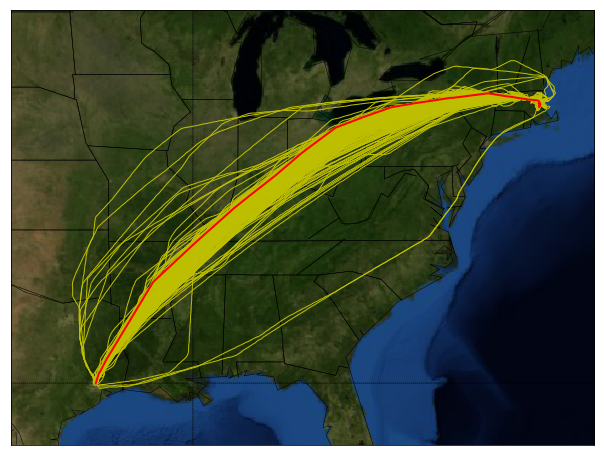

In [18]:
_, _ = plot_fp_act('FP_00002', FP_utlize, track_data, FP_track)

In [5]:
TestFID = [20130124258424, 20130124332972, 20130418757177, 20130419779669,
       20130529055061, 20130530150091, 20130530150779, 20130625265375,
       20130704053332, 20130714895734, 20130807052059, 20130807971681,
       20130808112315, 20130808113470, 20130808141462, 20130810273857,
       20130811392501, 20130901172600, 20130909740628, 20131018017749,
       20131021183608, 20131021192180, 20131022307104, 20131029881082,
       20131103253607, 20131106489872, 20131110821108, 20131111848631,
       20131111858283, 20131112913616, 20131113995880, 20131210032875,
       20131212180111]

In [7]:
TestFP = IAH_BOS_FP_utilize[IAH_BOS_FP_utilize.FID.isin(TestFID)].reset_index(drop = 1)
TestFP = IAH_BOS_ACT_track[IAH_BOS_ACT_track.FID.isin(TestFID)].groupby('FID').head(1)[['FID',\
            'Elap_Time']].reset_index(drop = 1).merge(TestFP,left_on = 'FID', right_on = 'FID')
TestFP_track = IAH_BOS_FP_track[IAH_BOS_FP_track.FLT_PLAN_ID.isin(TestFP.FLT_PLAN_ID.values)]

In [85]:
TestFP.to_csv('TestFP_ACT.csv', index = False)

In [ ]:
TestFP_track.to_csv('TestFP.csv', index = False)

In [64]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

TestFP_track['dist'] = \
    haversine_np(TestFP_track.LONGITUDE.shift(), TestFP_track.LATITUDE.shift(),
                 TestFP_track.ix[1:, 'LONGITUDE'], TestFP_track.ix[1:, 'LATITUDE'])

E:\Anaconda\Anaconda\lib\site-packages\IPython\kernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


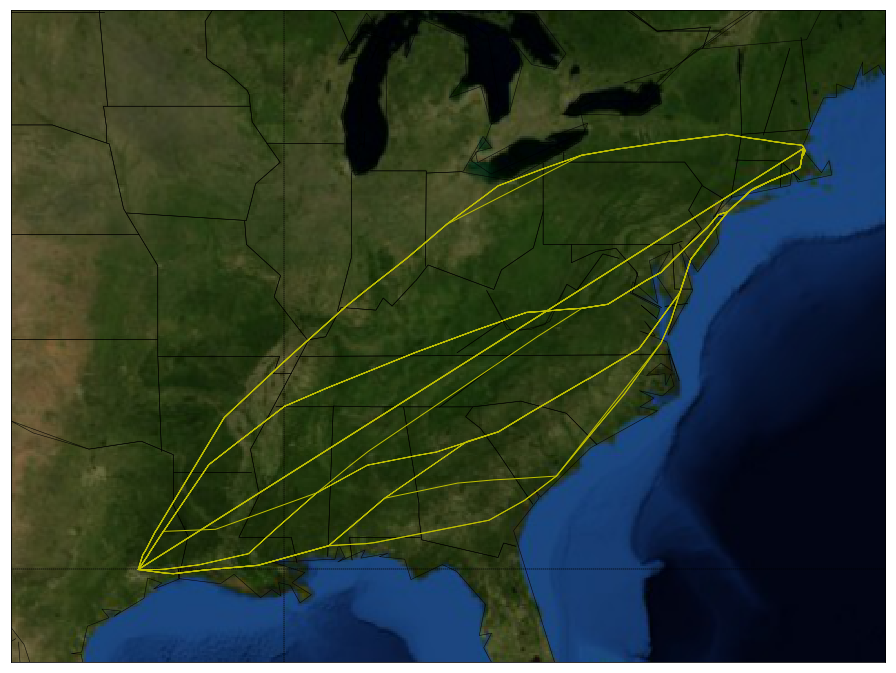

In [8]:
fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = -100,llcrnrlat = 27,urcrnrlon = -68,urcrnrlat = 46,projection='merc')
m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)
m.drawparallels(np.arange(10.,35.,5.))
m.drawmeridians(np.arange(-120.,-80.,10.))
for gpidx, gp in TestFP_track.groupby('FLT_PLAN_ID'):
    if gpidx == 'FP_00091':
        pass
    else:
        x,y = m(gp.LONGITUDE.values, gp.LATITUDE.values)
        FlightPlan, = plt.plot(x,y,'-', linewidth = 1, color='y', label = 'Flight Plans')
#     if gp.shape[0] <= MIN:
#         MIN = gp.shape[0]
#         print gp.shape[0], gpidx
#     plt.plot(gp.LONGITUDE, gp.LATITUDE, c='b')

In [4]:
DCA_ORD_FP = pd.read_csv(os.getcwd() + '/FlightPlans/FlightPlans_DCA_ORD_2013/FP_PT.CSV')

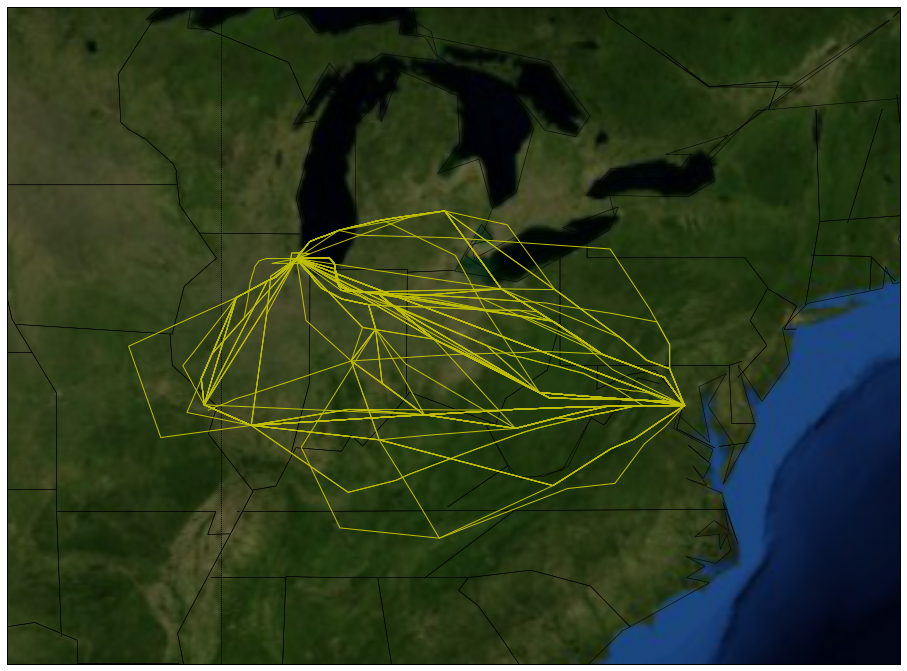

In [10]:
fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = -96,llcrnrlat = 33,urcrnrlon = -71,urcrnrlat = 47,projection='merc')
m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)
m.drawparallels(np.arange(10.,35.,5.))
m.drawmeridians(np.arange(-120.,-80.,10.))
for gpidx, gp in DCA_ORD_FP.groupby('FLT_PLAN_ID'):
    if gpidx == 'FP_00091':
        pass
    else:
        x,y = m(gp.LONGITUDE.values, gp.LATITUDE.values)
        FlightPlan, = plt.plot(x,y,'-', linewidth = 1, color='y', label = 'Flight Plans')
#     if gp.shape[0] <= MIN:
#         MIN = gp.shape[0]
#         print gp.shape[0], gpidx
#     plt.plot(gp.LONGITUDE, gp.LATITUDE, c='b')

In [2]:
# LA
DCA_ORD_LA_FP = pd.read_csv(os.getcwd() + '/FlightPlans/FlightPlans_LF_LA/DCA_ORD_LA_Flt_Plan_Pts_20130101_0131.CSV')

E:\Anaconda\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


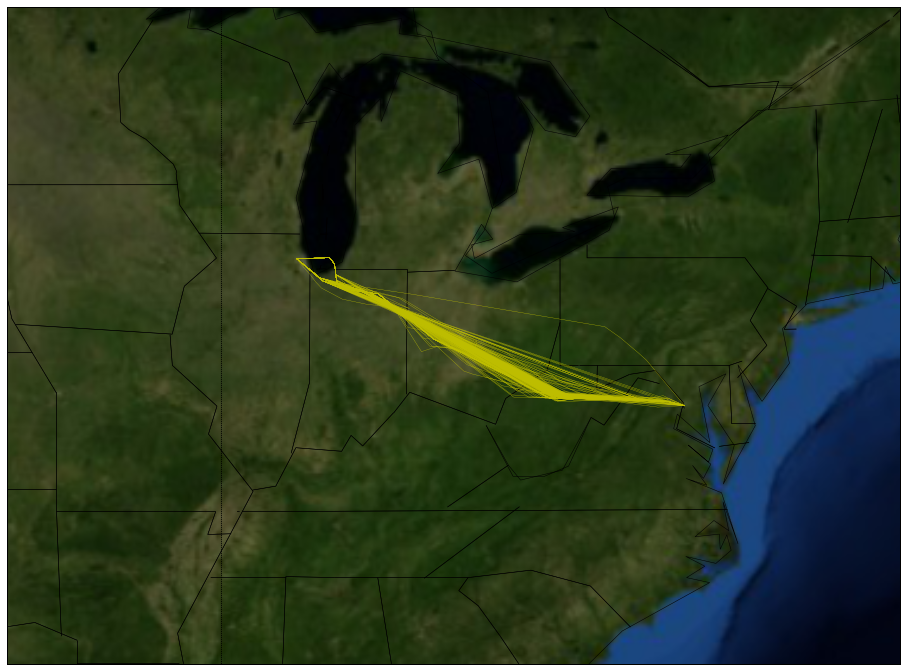

In [3]:
fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = -96,llcrnrlat = 33,urcrnrlon = -71,urcrnrlat = 47,projection='merc')
m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)
m.drawparallels(np.arange(10.,35.,5.))
m.drawmeridians(np.arange(-120.,-80.,10.))
for gpidx, gp in DCA_ORD_LA_FP.groupby('FLT_PLAN_ID'):
#     if gpidx == 'FP_00091':
#         pass
#     else:
    x,y = m(gp.LONGITUDE.values, gp.LATITUDE.values)
    FlightPlan, = plt.plot(x,y,'-', linewidth = 0.3, color='y', label = 'Flight Plans')
#     if gp.shape[0] <= MIN:
#         MIN = gp.shape[0]
#         print gp.shape[0], gpidx
#     plt.plot(gp.LONGITUDE, gp.LATITUDE, c='b')

27 FP_00001
27 FP_00004
24 FP_00005
10 FP_00008
10 FP_00012
9 FP_00048
2 FP_00065


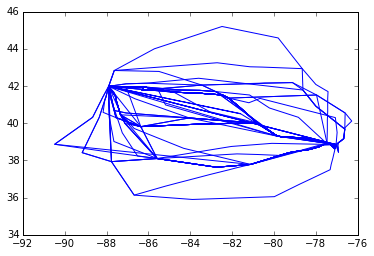

In [60]:
MIN = 999
for gpidx, gp in IAH_BOS_FP.groupby('FLT_PLAN_ID'):
    if gp.shape[0] <= MIN:
        MIN = gp.shape[0]
        print gp.shape[0], gpidx
    plt.plot(gp.LONGITUDE, gp.LATITUDE, c='b')

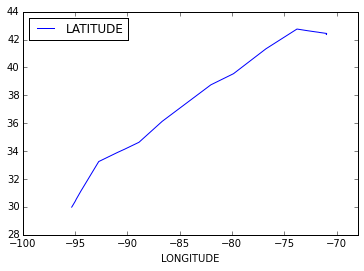

In [58]:
IAH_BOS_FP[IAH_BOS_FP.FLT_PLAN_ID=='FP_00053'].plot(x = 'LONGITUDE', y = 'LATITUDE', xlim = [-100,-68], ylim = [28,44])